# Description
Trains and evaluates XLNet token classification model with variant-only Wikipedia Homograph data only; one model for all labels.

### Imports

In [1]:
import os
import sys
import logging
from pathlib import Path
from statistics import mean 
import re
from glob import iglob
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple, TextIO
from transformers import AutoTokenizer, AutoModelForTokenClassification, XLNetForTokenClassification
from transformers import XLNetTokenizerFast, EvalPrediction
from transformers import Trainer, TrainingArguments
from transformers import AdamW
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
#from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score
#from pytorch_lightning.metrics.functional.classification import accuracy

### Variables

In [2]:
#Paths 
WHD_XLNET_DATA = "C:/Users/jseal/Dev/dissertation/Data/WHD_XLNet/variant_stratified_binary/"
WHD = 'C:/Users/jseal/Dev/dissertation/Data/WikipediaHomographData/data/'

# #Txt splits
# TRAIN_TXT = WHD_XLNET_DATA + "train.txt"
# DEV_TXT = WHD_XLNET_DATA + "dev.txt"
# TEST_TXT = WHD_XLNET_DATA + "test.txt"

#Logging path
LOGS = "./whd_variant_stratified_binary_logs"

# #Labels file
# LABELS = WHD_XLNET_DATA + "labels.txt"

#Homographs
#whd_df = pd.read_csv(WHD + 'WikipediaHomographData.csv')
#homographs = whd_df.drop_duplicates(subset='homograph')['homograph'].tolist()

# Model Variables
MAX_LENGTH = 128 #@param {type: "integer"}
BATCH_SIZE = 16 #@param {type: "integer"}
NUM_EPOCHS = 3 #@param {type: "integer"}
SAVE_STEPS = 100 #@param {type: "integer"}
LOGGING_STEPS = 100 #@param {type: "integer"}
SEED_1 = 15
SEED = 42 #@param {type: "integer"}
SEED_2 = 30
SEED_3 = 1234
SEED_4 = 500
STEPS = "steps"
EVAL_STEPS = 100
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01

MODEL_NAME = "xlnet-base-cased"
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

logger = logging.getLogger(__name__)

cuda:0


### Functions & classes

In [3]:
def read_set(file_path):
    token_docs = []
    tag_docs = []
    for text in iglob(file_path + '/*'):
        file_path = Path(text)

        raw_text = file_path.read_text(encoding="utf8").strip()
        raw_docs = re.split(r'\n\t?\n', raw_text)

        for doc in raw_docs:
            tokens = []
            tags = []
            for line in doc.split('\n'):
                _, token, tag = line.split('\t')
                token = token.strip()
                if token.isalpha(): 
                    if (len(token) == 1): 
                        if (token == 'a') or (token == 'I'):
                            tokens.append(token)
                            tags.append(tag)
                    else: 
                        tokens.append(token)
                        tags.append(tag)

            token_docs.append(tokens)
            tag_docs.append(tags)

    return token_docs, tag_docs

def get_tokens(encodings): 
    tokens = []
    for e in encodings: 
        tokens.append(e.tokens)
    return tokens

def encode_tags(tags, encodings):
    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = [] 
    for doc_labels, doc_offset, e in zip(labels, encodings.offset_mapping, encodings.encodings):
        indices = []
        for i, tok in enumerate(e.tokens):
            if len(tok) == 1:
                if tok == '▁':
                    indices.append(i)

        tokens = [v for i, v in enumerate(e.tokens) if i not in indices]
        doc_offset = [v for i, v in enumerate(doc_offset) if i not in indices]
        for i in range(len(indices)): 
            tokens.insert(0, '<PAD>')
            doc_offset.insert(0, (0,0))
        # create an empty array of -100
        doc_enc_labels = np.ones(len(doc_offset),dtype=int) * -100
        arr_offset = np.array(doc_offset)   

        #Set labels whose first offset position is 0 and second is not 0
        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels
        encoded_labels.append(doc_enc_labels.tolist())
    
    return encoded_labels

class WHDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
       # self.tokenizer = tokenizer
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
def align_predictions(predictions: np.ndarray, 
                      label_ids: np.ndarray) -> Tuple[List[int], List[int], List[str]]:
    preds = np.argmax(predictions, axis=2)

    batch_size, seq_len = preds.shape

    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            if label_ids[i, j] != nn.CrossEntropyLoss().ignore_index:
                out_label_list[i].append(id2tag[label_ids[i][j]])
                preds_list[i].append(id2tag[preds[i][j]])
    return preds_list, out_label_list

def homograph_check(preds_list, out_label_list, labels):
    '''Check that predictions to be evaluated are homographs, 
    not tokens from the sentence provided as context.'''
    pred_labels = zip(preds_list, out_label_list)
    unique_tags = [label.strip("\n") for label in open(labels).readlines()]
    preds = []
    labels = []
    for e in pred_labels:
        pred_label_pair = zip(e[0], e[1])
        for pred, label in pred_label_pair:
            if label is not 'O':
                preds.append(pred)
                labels.append(label)
    return labels, preds
    
def compute_metrics(p: EvalPrediction) -> Dict:
    '''Only compute metrics on homograph pronunciation predictions'''
    preds_list, labels_list = align_predictions(p.predictions, p.label_ids)
    targets, preds = homograph_check(preds_list, labels_list, labels)

    return {
        "accuracy_score": accuracy_score(targets, preds),
        "balanced_accuracy_score": balanced_accuracy_score(targets, preds)}

def write_predictions_to_file(writer: TextIO, test_input_reader: TextIO, preds_list: List):
    example_id = 0
    for line in test_input_reader:
        if line.startswith("-DOCSTART-") or line == "" or line == "\n":
            writer.write(line)
            if not preds_list[example_id]:
                example_id += 1
        elif preds_list[example_id]:
            output_line = line.split()[0] + " " + preds_list[example_id].pop(0) + "\n"
            writer.write(output_line)
        else:
            logger.warning("Maximum sequence length exceeded: No prediction for '%s'.", line.split()[0])

# Script

In [4]:
hom_paths = [f.path for f in os.scandir(WHD_XLNET_DATA) if f.is_dir()]
group_accuracies_for_mean = []
group_accuracies = []
for hom_path in hom_paths: 
    #Get unique labels, enumeration/IDs, and make mappings
    labels = hom_path + "/" + "labels.txt"
    unique_tags = [label.strip("\n") for label in open(labels).readlines()]
    tag2id = {tag: id for id, tag in enumerate(unique_tags)}
    id2tag = {id: tag for tag, id in tag2id.items()}
    
    #Make separate lists of aligned texts and tags
    train = hom_path + "/" + "train.txt"
    dev = hom_path + "/" + "dev.txt"
    test = hom_path + "/" + "test.txt"
    
    train_read = hom_path + "/" + "train"
    dev_read = hom_path + "/" + "dev"
    test_read = hom_path + "/" + "test"
    
    train_texts, train_tags = read_set(train_read)
    dev_texts, dev_tags = read_set(dev_read)
    test_texts, test_tags = read_set(test_read)
    
    #Make encodings for text 
    tokenizer = XLNetTokenizerFast.from_pretrained(MODEL_NAME, do_lower_case=False)
    train_encodings = tokenizer(train_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True)
    dev_encodings = tokenizer(dev_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True)
    
    #Make encodings for labels
    train_labels = encode_tags(train_tags, train_encodings)
    dev_labels = encode_tags(dev_tags, dev_encodings)
    
    #Make datasets
    train_encodings.pop("offset_mapping") # don't want to pass this to the model
    dev_encodings.pop("offset_mapping")
    train_dataset = WHDataset(train_encodings, train_labels)
    dev_dataset = WHDataset(dev_encodings, dev_labels)
    model = XLNetForTokenClassification.from_pretrained(MODEL_NAME,
                                                   num_labels=len(unique_tags))
    model.to(device)

    training_args = TrainingArguments(
        load_best_model_at_end=True,
        output_dir='./whd-variant-stratified-xlnet-model-tri',    # output directory
        num_train_epochs=NUM_EPOCHS,              # total # of training epochs
        per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
        per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
        warmup_steps=WARMUP_STEPS,                # number of warmup steps for learning rate scheduler
        weight_decay=WEIGHT_DECAY,                # strength of weight decay
        logging_dir=LOGS,                         # directory for storing logs
        evaluation_strategy=STEPS,
        eval_steps=EVAL_STEPS,
        seed=SEED_1,
        overwrite_output_dir=True,
    )

    trainer = Trainer(
        model=model,                         # instantiated Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_dataset,         # training dataset
        eval_dataset=dev_dataset,            # evaluation dataset
        compute_metrics=compute_metrics
    )

    trainer.train()
    trainer.evaluate()
    
    #EVAL
    predictions, label_ids, metrics = trainer.predict(dev_dataset)
    preds_list, targets_list = align_predictions(predictions, label_ids)
    targets_list, preds_list = homograph_check(preds_list, targets_list, labels)

    to_df = zip(preds_list, targets_list)
    print('Micro Accuracy')
    df = pd.DataFrame(to_df, columns=['Preds', 'Targets'])
    df_correct = df[df['Preds'] == df['Targets']]
    print(len(df_correct)/len(df))

    for idx, group in df.groupby('Targets'):
        grp = {}
        grp["wordid"] = idx
        print(idx)
        correct = group[group['Preds'] == group['Targets']]
        accuracy = len(correct)/len(group)
        print(accuracy)
        grp["accuracy"] = accuracy
        group_accuracies.append(grp)
        group_accuracies_for_mean.append(accuracy)
    print('Macro Accuracy')
    print(mean(group_accuracies_for_mean))
    
accuracies_df = pd.DataFrame(group_accuracies)
grp_acc_for_mean_df = pd.DataFrame(group_accuracies_for_mean)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-pack

Step,Training Loss,Validation Loss


C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Micro Accuracy
0.1
abuse_nou
0.0
abuse_vrb
1.0
Macro Accuracy
0.5


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.2
abuses_nou
0.0
abuses_vrb
1.0
Macro Accuracy
0.5


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
advocate_nou
0.0
advocate_vrb
0.0
Macro Accuracy
0.3333333333333333


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
affect
0.0
affect_nou-psy
0.0
Macro Accuracy
0.25


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.08333333333333333
affiliate_nou
0.0
affiliate_vrb
1.0
Macro Accuracy
0.3


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.7272727272727273
aged
0.8
aged_adj
0.0
Macro Accuracy
0.31666666666666665


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
aggregate_adj-nou
0.0
aggregate_vrb
0.0
Macro Accuracy
0.2714285714285714


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.9090909090909091
alternate_adj-nou
1.0
alternate_vrb
0.0
Macro Accuracy
0.3


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.2
analyses_nou
0.2222222222222222
analyses_vrb
0.0
Macro Accuracy
0.27901234567901234


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.1
animate_adj-nou
0.0
animate_vrb
0.16666666666666666
Macro Accuracy
0.2594444444444444


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
approximate_adj-nou
0.0
approximate_vrb
0.0
Macro Accuracy
0.23585858585858585


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.5
articulate_adj
0.25
articulate_vrb
0.6666666666666666
Macro Accuracy
0.25439814814814815


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
associate_adj-nou
0.0
associate_vrb
0.0
Macro Accuracy
0.23482905982905983


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
attribute_nou
0.0
attribute_vrb
0.0
Macro Accuracy
0.21805555555555556


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
axes_nou
0.0
axes_nou-vrb
0.0
Macro Accuracy
0.20351851851851852


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
bass
0.0
bass_corp
0.0
Macro Accuracy
0.1907986111111111


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.2222222222222222
blessed_adj
0.0
blessed_vrb
0.4
Macro Accuracy
0.19133986928104574


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.4
bow_nou-knot
0.0
bow_nou-ship
0.6666666666666666
Macro Accuracy
0.1992283950617284


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
buffet_nou
0.0
buffet_vrb
0.0
Macro Accuracy
0.18874269005847955


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.2
celtic
0.0
celtic_adj-nou-sports
0.6666666666666666
Macro Accuracy
0.19597222222222221


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
close_adj-nou
0.0
close_vrb
0.0
Macro Accuracy
0.18664021164021163


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.1
combine_nou
1.0
combine_vrb
0.0
Macro Accuracy
0.2008838383838384


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.25
compound_nou
0.18181818181818182
compound_vrb
1.0
Macro Accuracy
0.21784145805884936


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.18181818181818182
compress
0.1
compress_nou
1.0
Macro Accuracy
0.2316813973063973


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.6
conduct_nou
0.4
conduct_vrb
0.8
Macro Accuracy
0.24641414141414142


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.1
confines_nou
0.0
confines_vrb
0.5
Macro Accuracy
0.24655205905205904


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
conflict_nou
0.0
conflict_vrb
0.0
Macro Accuracy
0.2374205013093902


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.16666666666666666
conjugate_adj-nou
0.09090909090909091
conjugate_vrb
1.0
Macro Accuracy
0.24842171717171718


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.4
conscript_nou
0.25
conscript_vrb
1.0
Macro Accuracy
0.2614071752002787


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.5
construct_nou
0.0
construct_vrb
0.5555555555555556
Macro Accuracy
0.26195286195286194


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
consummate_adj
0.0
consummate_vrb
0.0
Macro Accuracy
0.2535027696318019


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
content_adj-nou-vrb
0.0
content_nou
0.0
Macro Accuracy
0.2455808080808081


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.1
contest_nou
0.0
contest_vrb
0.5
Macro Accuracy
0.24571472298745026


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
converse_adj-nou
0.0
converse_vrb
0.0
Macro Accuracy
0.2384878193701723


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.1
convert_nou
0.0
convert_vrb
0.125
Macro Accuracy
0.23345959595959595


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
convict_nou
0.0
convict_vrb
0.0
Macro Accuracy
0.22697460718294052


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
coordinate_adj-nou
0.0
coordinate_vrb
0.0
Macro Accuracy
0.22084015834015835


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
correlate_nou
0.0
correlate_nou-vrb
0.0
Macro Accuracy
0.21502857522594365


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
decrease_nou
0.0
decrease_vrb
0.0
Macro Accuracy
0.209515022015022


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.1
defect_nou
0.0
defect_vrb
1.0
Macro Accuracy
0.21677714646464646


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.1
degenerate_adj-nou
0.0
degenerate_vrb
0.5
Macro Accuracy
0.21758745996550874


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
delegate_nou
0.0
delegate_vrb
0.0
Macro Accuracy
0.21240680615680615


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
deliberate_adj
0.0
deliberate_vrb
0.0
Macro Accuracy
0.2074671129903688


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.8
diagnoses_nou
1.0
diagnoses_vrb
0.0
Macro Accuracy
0.21411558769513314


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
diffuse_adj
0.0
diffuse_vrb
0.0
Macro Accuracy
0.2093574635241302


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.1
discard_nou
0.0
discard_vrb
0.125
Macro Accuracy
0.2061649099692578


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.1
discharge_nou
0.0
discharge_vrb
1.0
Macro Accuracy
0.2124167203954438


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
discount_nou
0.0
discount_vrb
0.0
Macro Accuracy
0.20799137205387205


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
document_nou
0.0
document_vrb
0.0
Macro Accuracy
0.20374665017522162


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.14285714285714285
dove
0.0
dove_vrb
1.0
Macro Accuracy
0.20967171717171718


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.4
duplicate_adj-nou
0.375
duplicate_vrb
0.5
Macro Accuracy
0.21413893840364429


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
escort_nou
0.0
escort_vrb
0.0
Macro Accuracy
0.2100208818958819


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
estimate_nou
0.0
estimate_vrb
0.0
Macro Accuracy
0.206058223746903


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
excuse_nou
0.0
excuse_vrb
0.0
Macro Accuracy
0.20224233071455294


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.8
exploit_nou
0.0
exploit_vrb
1.0
Macro Accuracy
0.2076561065197429


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
export_nou
0.0
export_vrb
0.0
Macro Accuracy
0.20394796176046176


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.45454545454545453
expose_nou
0.0
expose_vrb
0.5
Macro Accuracy
0.20475589225589225


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.5454545454545454
extract_nou
1.0
extract_vrb
0.0
Macro Accuracy
0.20984630790665273


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
fragment_nou
0.0
fragment_vrb
0.0
Macro Accuracy
0.20628959082348913


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.8181818181818182
frequent_adj
0.9
frequent_vrb
0.0
Macro Accuracy
0.21035143097643097


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.3333333333333333
graduate_adj-nou
0.2
graduate_vrb
1.0
Macro Accuracy
0.21673911243583374


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.09090909090909091
impact_nou
0.0
impact_vrb
1.0
Macro Accuracy
0.22130783642880417


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.3
implant_nou
0.2222222222222222
implant_vrb
1.0
Macro Accuracy
0.22749518999519


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.1
implement_nou
0.0
implement_vrb
0.1111111111111111
Macro Accuracy
0.2248086332070707


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
import_nou
0.0
import_vrb
0.0
Macro Accuracy
0.22135003885003884


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.9166666666666666
incline_nou
1.0
incline_vrb
0.0
Macro Accuracy
0.2255720079583716


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.6666666666666666
increase_nou
1.0
increase_vrb
0.0
Macro Accuracy
0.2296679481380974


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
increment_nou
0.0
increment_vrb
0.0
Macro Accuracy
0.22629047831253712


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
initiate_nou
0.0
initiate_vrb
0.0
Macro Accuracy
0.22301090616308009


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
insert_nou
0.0
insert_vrb
0.0
Macro Accuracy
0.21982503607503606


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
insult_nou
0.0
insult_vrb
0.0
Macro Accuracy
0.2167289088063736


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
intrigue_nou
0.0
intrigue_nou-vrb
0.0
Macro Accuracy
0.21371878507295175


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.1
invalid_adj
0.125
invalid_nou
0.0
Macro Accuracy
0.21164729486647296


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.7
invert_adj-nou
0.3333333333333333
invert_vrb
0.8571428571428571
Macro Accuracy
0.21683095433095434


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.3
invite_nou
0.0
invite_vrb
0.375
Macro Accuracy
0.21643987493987493


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
isolate
0.0
isolate_nou
0.0
Macro Accuracy
0.2135919818485608


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
laminate_nou
0.0
laminate_vrb
0.0
Macro Accuracy
0.21081806000637168


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.18181818181818182
lead_nou
0.0
lead_nou-vrb
0.2222222222222222
Macro Accuracy
0.2095397657897658


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
learned_adj
0.0
learned_vrb
0.0
Macro Accuracy
0.20688736369116115


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.2727272727272727
live_adj
0.0
live_vrb
0.75
Macro Accuracy
0.20898877164502164


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.2
lives_nou
0.0
lives_vrb
0.3333333333333333
Macro Accuracy
0.20846627652183208


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
minute
0.0
minute_adj
0.0
Macro Accuracy
0.20592400485693169


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
misuse_nou
0.0
misuse_vrb
0.0
Macro Accuracy
0.20344299275022165


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.9090909090909091
mobile
1.0
mobile_geo
0.0
Macro Accuracy
0.20697343331271903


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.7777777777777778
nestle_nam
1.0
nestle_vrb
0.0
Macro Accuracy
0.21042080468551055


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.09090909090909091
ornament_nou
0.1
ornament_vrb
0.0
Macro Accuracy
0.208555446491493


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.2
overthrow_nou
0.0
overthrow_vrb
0.3333333333333333
Macro Accuracy
0.20807396626362143


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
pasty_adj
0.0
pasty_nou
0.0
Macro Accuracy
0.2057094893742621


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.5
perfect_adj
0.5454545454545454
perfect_vrb
0.0
Macro Accuracy
0.20646249817598133


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
perfume_nou
0.0
perfume_vrb
0.0
Macro Accuracy
0.20416847041847042


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.4
permit_nou
0.0
permit_vrb
1.0
Macro Accuracy
0.20741936634793778


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.4
pervert_nou
0.25
pervert_vrb
1.0
Macro Accuracy
0.21195828627893845


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.25
polish
0.0
polish_geo
0.2727272727272727
Macro Accuracy
0.21114544058092446


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.3
postulate_nou
0.0
postulate_vrb
0.75
Macro Accuracy
0.21288857419176568


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
precipitate_adj-nou
0.0
precipitate_vrb
0.0
Macro Accuracy
0.21064764183185236


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
present_adj-nou
0.0
present_vrb
0.0
Macro Accuracy
0.20845339556277057


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
produce_nou
0.0
produce_vrb
0.0
Macro Accuracy
0.20630439148480387


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.1
progress_nou
0.0
progress_vrb
0.5
Macro Accuracy
0.20675026504108138


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.4
protest_nou
0.4444444444444444
protest_vrb
0.0
Macro Accuracy
0.20690654743685047


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
read_past
0.0
read_present
0.0
Macro Accuracy
0.20483748196248197


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
reading_en
0.0
reading_geo
0.0
Macro Accuracy
0.20280938808166532


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
rebel_nou
0.0
rebel_vrb
0.0
Macro Accuracy
0.20082106074753134


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
record_nou
0.0
record_vrb
0.0
Macro Accuracy
0.19887134171114754


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
recount_nou
0.0
recount_vrb
0.0
Macro Accuracy
0.19695911727161727


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
refund_nou
0.0
refund_vrb
0.0
Macro Accuracy
0.19508331615474472


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.2
refuse_nou
0.0
refuse_vrb
0.25
Macro Accuracy
0.1944221527947943


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.2222222222222222
reject_nou
0.0
reject_vrb
0.25
Macro Accuracy
0.1937733476284878


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
rerelease
0.0
rerelease_vrb
0.0
Macro Accuracy
0.19197914996526108


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.1
resume_nou
0.0
resume_vrb
0.1111111111111111
Macro Accuracy
0.19072755735599772


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.2
retard_nou
1.0
retard_vrb
0.0
Macro Accuracy
0.19353912501639775


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.6666666666666666
rodeo
0.7272727272727273
rodeo_geo
0.0
Macro Accuracy
0.19507153257153256


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.3
sake
0.375
sake_jp
0.0
Macro Accuracy
0.19500392960214388


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.09090909090909091
separate_adj
0.1
separate_vrb
0.0
Macro Accuracy
0.1937207089861957


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.1
sow
0.0
sow_nou
0.25
Macro Accuracy
0.1931178957494747


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.18181818181818182
subordinate_adj-nou
0.1
subordinate_vrb
1.0
Macro Accuracy
0.19622121839513143


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.3
supplement_nou
0.3333333333333333
supplement_vrb
0.25
Macro Accuracy
0.19704402398367915


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
suspect_adj-nou
0.0
suspect_vrb
0.0
Macro Accuracy
0.19535988702655369


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.08333333333333333
syndicate_nou
0.09090909090909091
syndicate_vrb
0.0
Macro Accuracy
0.19408950277594345


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.36363636363636365
tear_nou
0.0
tear_vrb
0.5714285714285714
Macro Accuracy
0.19485945893508919


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.1
transform
0.14285714285714285
transform_nou
0.0
Macro Accuracy
0.1938308682058682


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
transplant_nou
0.0
transplant_vrb
0.0
Macro Accuracy
0.19222896020416683


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.09090909090909091
transport_nou
0.0
transport_vrb
1.0
Macro Accuracy
0.19475167364511628


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.6666666666666666
upset_nou
0.8571428571428571
upset_vrb
0.0
Macro Accuracy
0.19665264726240336


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.1
use_nou
0.0
use_vrb
0.25
Macro Accuracy
0.19607480333286784


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
uses_nou
0.0
uses_vrb
0.0
Macro Accuracy
0.1945062049062049


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
wind_nou
0.0
wind_vrb
0.0
Macro Accuracy
0.19296250486726677


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.0
winds_nou
0.0
winds_vrb
0.0
Macro Accuracy
0.19144311506516232


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Micro Accuracy
0.5
wound_nou-vrb
0.16666666666666666
wound_vrb
1.0
Macro Accuracy
0.1945047573953824


In [43]:
all_accuracies = accuracies_df.accuracy.tolist()

In [44]:
sum(all_accuracies)/len(accuracies_df)

0.19450475739538242

In [ ]:
pd.set_option('display.max_rows', None)

In [5]:
accuracies_df.sort_values("accuracy")

,wordid,accuracy
0,abuse_nou,0.0
112,expose_nou,0.0
205,record_vrb,0.0
204,record_nou,0.0
115,extract_vrb,0.0
...,...,...
57,conscript_vrb,1.0
55,conjugate_vrb,1.0
229,subordinate_vrb,1.0
114,extract_nou,1.0


In [6]:
hids = pd.read_csv("C:/Users/jseal/Dev/dissertation/Data_Exploration/WHD/hids.csv")

In [7]:
hids_acc = pd.merge(hids, accuracies_df, on='wordid')

In [8]:
hids_acc.sort_values(["accuracy"])

,Unnamed: 0,homograph,wordid,wordid_count,ttl,percent_ttl,accuracy
0,0,abuse,abuse_nou,81,90,0.900000,0.0
145,1,invalid,invalid_nou,22,89,0.247191,0.0
149,1,invite,invite_nou,19,90,0.211111,0.0
150,0,isolate,isolate_nou,21,90,0.233333,0.0
151,1,isolate,isolate,69,90,0.766667,0.0
...,...,...,...,...,...,...,...
47,1,compress,compress_nou,4,88,0.045455,1.0
45,1,compound,compound_vrb,3,90,0.033333,1.0
43,1,combine,combine_nou,8,89,0.089888,1.0
86,0,diagnoses,diagnoses_nou,70,90,0.777778,1.0


In [40]:
hids_acc = hids_acc[hids_acc['accuracy'] > 0.7]

In [41]:
hids_acc_prevalence = hids_acc[["wordid", "percent_ttl"]]
hids_acc_acc = hids_acc[["wordid", "accuracy"]]

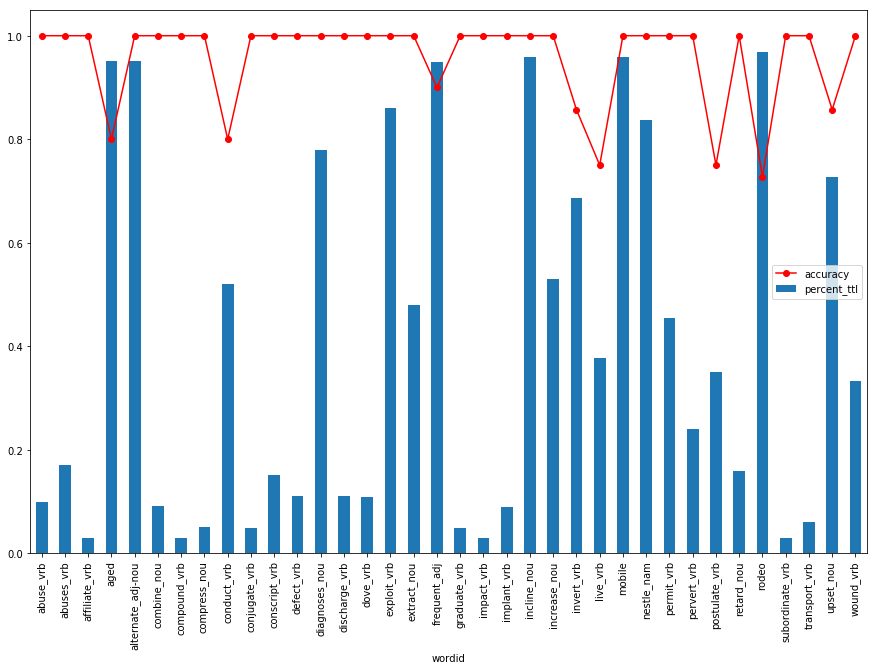

In [42]:
import matplotlib.pylab as plt
%matplotlib inline  

ax = hids_acc_acc.plot(
    x='wordid', linestyle='-', marker='o', color="red")
hids_acc_prevalence.plot(x='wordid', kind='bar', ax=ax, figsize=(15,10))

plt.show()

In [39]:
hids_acc = pd.merge(hids, accuracies_df, on='wordid')
homs = hids_acc[hids_acc["percent_ttl"] < 0.2]['homograph'].tolist()
homs

['abuse',
 'abuses',
 'advocate',
 'affect',
 'affiliate',
 'aged',
 'aggregate',
 'alternate',
 'analyses',
 'approximate',
 'associate',
 'bass',
 'buffet',
 'close',
 'combine',
 'compound',
 'compress',
 'conflict',
 'conjugate',
 'conscript',
 'construct',
 'content',
 'contest',
 'convert',
 'convict',
 'correlate',
 'defect',
 'degenerate',
 'delegate',
 'deliberate',
 'discharge',
 'discount',
 'document',
 'dove',
 'escort',
 'excuse',
 'exploit',
 'export',
 'expose',
 'fragment',
 'frequent',
 'graduate',
 'impact',
 'implant',
 'implement',
 'incline',
 'increment',
 'initiate',
 'intrigue',
 'laminate',
 'learned',
 'minute',
 'misuse',
 'mobile',
 'nestle',
 'ornament',
 'perfect',
 'perfume',
 'polish',
 'present',
 'produce',
 'progress',
 'protest',
 'reading',
 'rebel',
 'record',
 'refuse',
 'reject',
 'rerelease',
 'resume',
 'retard',
 'rodeo',
 'sake',
 'separate',
 'subordinate',
 'syndicate',
 'transplant',
 'transport',
 'uses',
 'wind',
 'winds']

In [22]:
len(homs)

81

In [14]:
hids_acc['homograph'].nunique()

128

# Train and eval together

In [15]:
hids = pd.read_csv("C:/Users/jseal/Dev/dissertation/Data_Exploration/WHD/train_eval_hids.csv")

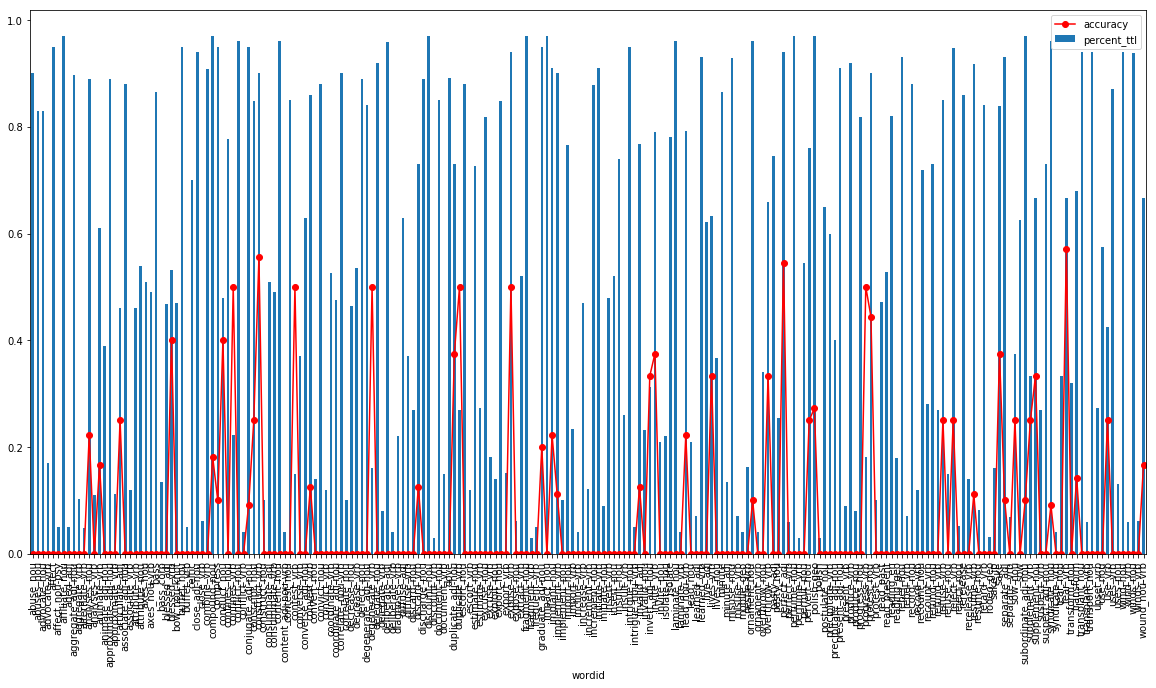

In [23]:
hids_acc = pd.merge(hids, accuracies_df, on='wordid')
hids_acc = hids_acc[hids_acc['accuracy'] < 0.6]
hids_acc_prevalence = hids_acc[["wordid", "percent_ttl"]]
hids_acc_acc = hids_acc[["wordid", "accuracy"]]
ax = hids_acc_acc.plot(
    x='wordid', linestyle='-', marker='o', color="red")
hids_acc_prevalence.plot(x='wordid', kind='bar', ax=ax, figsize=(20,10))

plt.show()

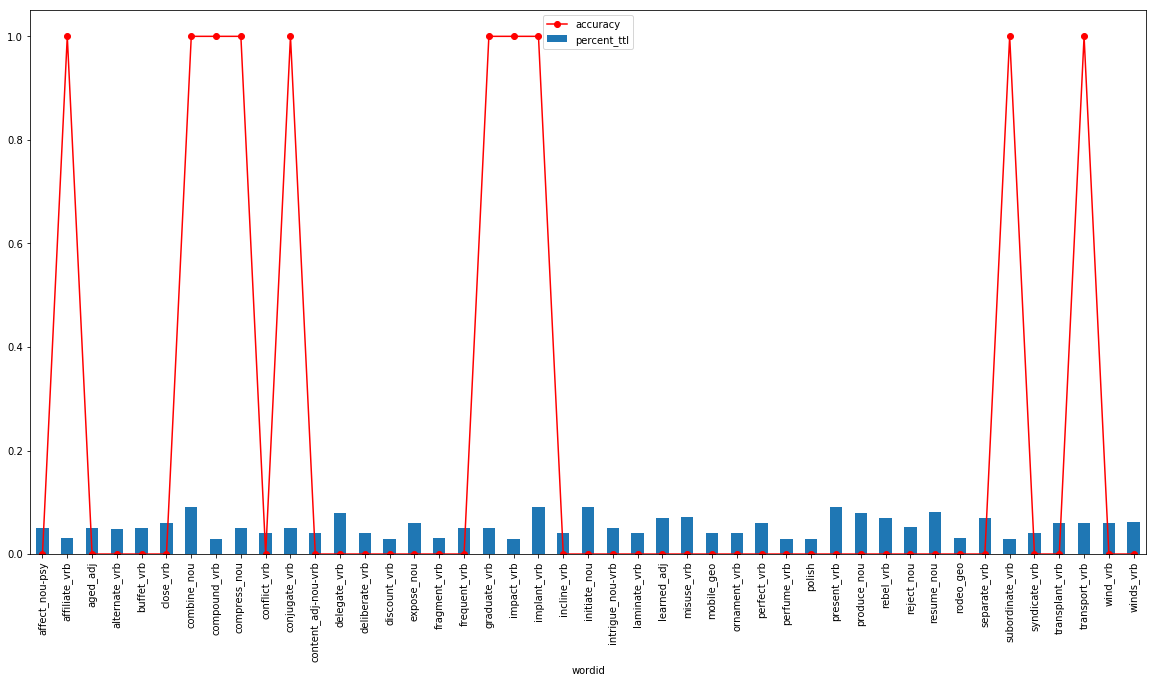

In [24]:
hids_acc = pd.merge(hids, accuracies_df, on='wordid')
hids_acc = hids_acc[hids_acc['percent_ttl'] < 0.1]
hids_acc_prevalence = hids_acc[["wordid", "percent_ttl"]]
hids_acc_acc = hids_acc[["wordid", "accuracy"]]
ax = hids_acc_acc.plot(
    x='wordid', linestyle='-', marker='o', color="red")
hids_acc_prevalence.plot(x='wordid', kind='bar', ax=ax, figsize=(20,10))

plt.show()

In [25]:
#WITH SEED_2
#Instantiate model, training args and trainer; train and evaluate
# config = DistilBertConfig.from_pretrained(MODEL_NAME, 
#                                           output_hidden_states=True, 
#                                           #idx2label=id2tag, 
#                                           num_labels=len(unique_tags))
# model = DistilBertForTokenClassification.from_pretrained(MODEL_NAME,config=config)
model = XLNetForTokenClassification.from_pretrained(MODEL_NAME,
                                                         num_labels=len(unique_tags))
model.to(device)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir='./whd-variant-stratfied-model',    # output directory
    num_train_epochs=NUM_EPOCHS,              # total # of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=WARMUP_STEPS,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,                # strength of weight decay
    logging_dir=LOGS,                         # directory for storing logs
    evaluation_strategy=STEPS,
    eval_steps=EVAL_STEPS,
    seed=SEED_2,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,                         # instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

KeyboardInterrupt: 

In [ ]:
#WITH SEED_3
#Instantiate model, training args and trainer; train and evaluate
# config = DistilBertConfig.from_pretrained(MODEL_NAME, 
#                                           output_hidden_states=True, 
#                                           #idx2label=id2tag, 
#                                           num_labels=len(unique_tags))
# model = DistilBertForTokenClassification.from_pretrained(MODEL_NAME,config=config)
model = XLNetForTokenClassification.from_pretrained(MODEL_NAME,
                                                         num_labels=len(unique_tags))
model.to(device)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir='./whd-variant-stratified-model',    # output directory
    num_train_epochs=NUM_EPOCHS,              # total # of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=WARMUP_STEPS,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,                # strength of weight decay
    logging_dir=LOGS,                         # directory for storing logs
    evaluation_strategy=STEPS,
    eval_steps=EVAL_STEPS,
    seed=SEED_3,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,                         # instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

In [ ]:
#WITH SEED_4
#Instantiate model, training args and trainer; train and evaluate
# config = DistilBertConfig.from_pretrained(MODEL_NAME, 
#                                           output_hidden_states=True, 
#                                           #idx2label=id2tag, 
#                                           num_labels=len(unique_tags))
# model = DistilBertForTokenClassification.from_pretrained(MODEL_NAME,config=config)
model = XLNetForTokenClassification.from_pretrained(MODEL_NAME,
                                                         num_labels=len(unique_tags))
model.to(device)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir='./whd-variant-stratified-model',    # output directory
    num_train_epochs=NUM_EPOCHS,              # total # of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=WARMUP_STEPS,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,                # strength of weight decay
    logging_dir=LOGS,                         # directory for storing logs
    evaluation_strategy=STEPS,
    eval_steps=EVAL_STEPS,
    seed=SEED_4,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,                         # instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()